# ML Algorithms for Predicting Indoor Locations

**Datasets**:    UJIIndoorLoc_trainingData.csv (training/validation set), UNJIndoorLoc_validationData.csv (test set)

**Scenario**:    Determine the feasbility of using Wi-Fi fingerprints indoor smartphone locationing.
             
**Goal**:        Benchmark 3 indoor locationing solutions using the UJIIndoorLoc dataset from http://archive.ics.uci.edu/ml/datasets/UJIIndoorLoc. In this script, we'll use a random forest classifier.
 
             
- Tuned random forest: "RandomForestClassifier_model.sav"
  - criterion: gini
  - max_depth: not limited
  - max_features: sqrt (The number of features to consider when 
  - looking for the best split)
  - n_estimators: 60 (number of trees in the forest)
  
             
- Tuning insights: See "tuning_rf.csv" for results of all hyperparameter combinations tried. For this dataset, the Gini splitting criterion generally performed better. Limiting the maximum depth of trees hindered performance. Using the square root of the number of features as the number of features to consider at each split was better than log2 and any percentage between 30 to 90% of the total number of features. More trees generally reduced overfitting, but increased memory usage during training considerably. Due to limited PC memory, the number of trees was limited to 60 trees in the best model.
             
             
- Reason: gives good cross-validation scores. There's slight overfitting, suggested by the 11% gap between the cross-validation scores and the average training fold scores, which can be improved if not limited by PC ram.

             
- Training set performance (average of k-folds): accuracy 0.968 kappa 0.968  

             
- Cross validation performance: accuracy 0.856 kappa 0.8554

  
- Test set performance: 

  - mean positional error 8.579 m
  - 25th percentile       1.466 m
  - 50th percentile       5.551 m
  - 75th percentile       11.218 m
  - 95th percentile       28.303 m
  - 100th percentile      94.208 m
  - Building hitrate      100%
  - Floor hitrate         90.4%

# Imports

In [2]:
#!pip3 install pandas
#!pip3 install scikit-learn
#!pip3 install xgboost==0.82
#!pip install modin[all]

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import glob
import math
import pickle
import xgboost as xgb

# Import Data

In [3]:
# training/validation set
train_set = pd.read_csv("UJIIndoorLoc_trainingData.csv")

# test set
test_set = pd.read_csv("UJIIndoorLoc_validationData.csv")

# Evaluate Data

Training/validation Set

In [4]:
train_set.loc[train_set["BUILDINGID"] == 0]["FLOOR"].unique() # building 0 has 4 floors


array([0, 2, 1, 3], dtype=int64)

In [5]:
train_set.loc[train_set["BUILDINGID"] == 1]["FLOOR"].unique() # building 1 has 4 floors

array([2, 0, 1, 3], dtype=int64)

In [6]:
train_set.loc[train_set["BUILDINGID"] == 2]["FLOOR"].unique() # building 2 has 5 floors

array([3, 2, 4, 1, 0], dtype=int64)

In [7]:
train_set.columns.values

array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

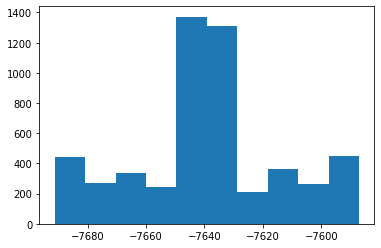

In [8]:
plt.hist(train_set.loc[train_set["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()
# Almost all fingerprints were collected right outside the door to each 
# fingerprint's SPACEID location.
# Building 0 fingerprints were collected by just 2 devices (and 2 separate 
# users). Not a lot of variety in different devices.

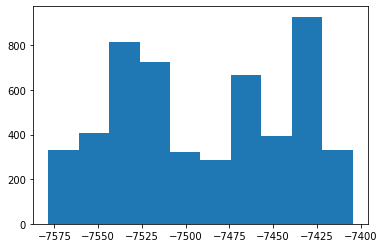

In [9]:
plt.hist(train_set.loc[train_set["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

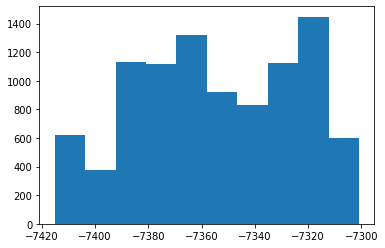

In [10]:
plt.hist(train_set.loc[train_set["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

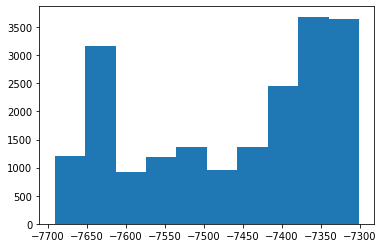

In [11]:
plt.hist(train_set["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

In [12]:
# check for missing values
pd.isnull(train_set)
pd.isnull(train_set).values.any()
# No missing values 

False

Test Set

In [13]:
test_set.loc[test_set["BUILDINGID"] == 0]["FLOOR"].unique() # building 0 has 4 floors

array([2, 1, 0, 3], dtype=int64)

In [14]:
test_set.loc[test_set["BUILDINGID"] == 1]["FLOOR"].unique() # building 1 has 4 floors

array([1, 3, 2, 0], dtype=int64)

In [15]:
test_set.loc[test_set["BUILDINGID"] == 2]["FLOOR"].unique() # building 2 has 5 floors

array([4, 2, 3, 0, 1], dtype=int64)

In [16]:
test_set.columns.values

array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

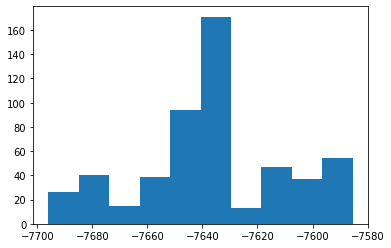

In [17]:
plt.hist(test_set.loc[test_set["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()

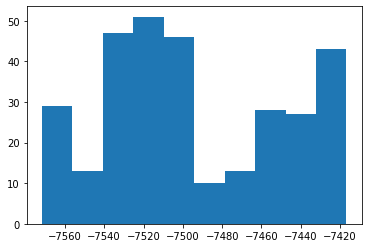

In [18]:
plt.hist(test_set.loc[test_set["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()

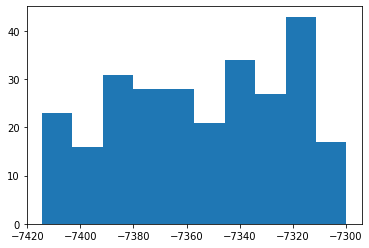

In [19]:
plt.hist(test_set.loc[test_set["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()

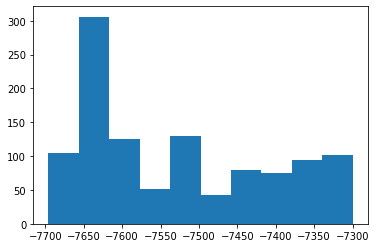

In [20]:
plt.hist(test_set["LONGITUDE"])
plt.show()

In [21]:
# check for missing values
pd.isnull(test_set)
pd.isnull(test_set).values.any()
# No missing values

False

# Preprocess Data and Feature Engineering

Training/validation Set

In [22]:
# Fingerprint data representation: positive-value representation for all WAPs.
# Original representation: -104 to 0 (weak to strong), 100 for no signal.
# New represenation: 1 to 105 (weak to strong), 0 for no signal.
train_set.iloc[:, 0:520].min().min() # minimum WAP is -104 dBm
train_set_P = train_set.copy()
train_set_P.iloc[:, 0:520] = np.where(train_set_P.iloc[:, 0:520] <= 0, 
                train_set_P.iloc[:, 0:520] + 105, 
                train_set_P.iloc[:, 0:520] - 100) 

In [ ]:
# Feature Scaling - do not center - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

In [23]:
# Create a single label for the model to predict. FLOOR, LATITUDE, FLOOR, and 
# BUILDINGID pinpoints the exact location of a user inside a building. Stack 
# train set and test set first before assigning unique location so that 
# identical locations are assigned the same UNIQUELOCATION value.
combined = pd.concat([train_set_P, test_set]) # stack vertically
combined = combined.assign(UNIQUELOCATION = (combined['LONGITUDE'].astype(str) + '_' + combined['LATITUDE'].astype(str) + '_' + combined['FLOOR'].astype(str) + '_' + combined['BUILDINGID'].astype(str)).astype('category').cat.codes)
len(combined["UNIQUELOCATION"].unique()) # 1995 unique locations

1997

In [24]:
# split again
train_set_PU = combined.iloc[0:19937, :]
test_set_U = combined.iloc[19937:21048, :]

In [ ]:
# Change variable types
train_set_PU["UNIQUELOCATION"] = train_set_PU["UNIQUELOCATION"].astype("category")
train_set_PU.dtypes

In [26]:
X_train = train_set_PU.iloc[:, 0:520]
y_train = train_set_PU.iloc[:, 520:530]

Test Set

In [27]:
# Fingerprint data representation
test_set_PU = test_set_U.copy()
test_set_PU.iloc[:, 0:520] = np.where(test_set_PU.iloc[:, 0:520] <= 0, test_set_PU.iloc[:, 0:520] + 105, test_set_PU.iloc[:, 0:520] - 100) 

In [28]:
# Feature Scaling - do not center this data - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

In [28]:
test_set_PU["UNIQUELOCATION"] = test_set_PU["UNIQUELOCATION"].astype("category")
test_set_PU.dtypes

WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object

In [29]:
X_test = test_set_PU.iloc[:, 0:520]
y_test = test_set_PU.iloc[:, 520:530]

In [30]:
# Create a reference table for looking up the LONGITUDE, LATITUDE, FLOOR, and 
# BUILDINGID associated with each UNIQUELOCATION value.
ref_table = pd.concat([y_train.iloc[:, [0,1,2,3,9]], y_test.iloc[:, [0,1,2,3,9]]])
ref_table = ref_table.drop_duplicates()

In [31]:
#--- save data ---#
def save_data(dataframe, filename):
    file_present = glob.glob(filename) # boolean, file already present?
    if not file_present:
        dataframe.to_csv(filename)
    else:
        print('WARNING: This file already exists.')

In [32]:
save_data(X_train, 'X_train_rf.csv')
save_data(y_train, 'y_train_rf.csv')
save_data(X_test, 'X_test_rf.csv')
save_data(y_test, 'y_test_rf.csv')

In [33]:
#--- load data ---#
X_train = pd.read_csv('X_train_rf.csv', index_col = 0)
y_train = pd.read_csv('y_train_rf.csv', index_col = 0)
X_test = pd.read_csv('X_test_rf.csv', index_col = 0)
y_test = pd.read_csv('y_test_rf.csv', index_col = 0)

In [34]:
#-- delete unneeded datasets created during preprocessing to free up memory --#
del train_set, train_set_P, train_set_PU, test_set, test_set_U, test_set_PU, combined

# Train Model(s)

Random Forest

In [35]:
# Using cross-validation, train best random forest model to predict 
# UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
# for cross-validation and on the training set. We report location error metrics
# on the test set.

if __name__ == '__main__':
    
    # Select model
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier(random_state = 0)
    
    # Apply k-fold cross-validation with grid search
    from sklearn.model_selection import GridSearchCV
    # 'parameters' can be a list of dictionaries for more specificity in 
    # hyperparamter combinations to attempt.
    # hyperparameters: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    # for a list of hyperparameters tried, see "tuning_rf.csv"
    hyperparameters = {'criterion': ['gini'], 
                  'max_depth': [None], 
                  'max_features': ['sqrt'],
                  'n_estimators': [60]}
    
    from sklearn.metrics import cohen_kappa_score
    from sklearn.metrics import make_scorer
    scoring = {'accuracy': 'accuracy',
               'kappa': make_scorer(cohen_kappa_score)}
    
    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters,
                        scoring = scoring,
                        cv = 10,
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing
    
    tic = time.time()
    grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    import winsound; winsound.Beep(frequency = 1500, duration = 2000) 

In [36]:
#--- cross validation metrics and training set metrics (average of folds) ----#
cv_results_ = pd.DataFrame.from_dict(grid_result.cv_results_) 
cv_results_.insert(loc = 0, column = 'Model', 
                   value = ['RandomForestClassifier']*cv_results_.shape[0])
cv_results_.insert(loc = 60, column = 'mean train - cross_val accuracy', 
                   value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
cv_results_.insert(loc = 61, column = 'mean train - cross_val kappa', 
                   value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
with open('tuning_rf.csv', 'a') as f:
    cv_results_.to_csv(f, header = True)

In [37]:
grid_result.best_estimator_
grid_result.best_score_
grid_result.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 60}

In [38]:
#--- save best model ---#

def save_model(model, model_name):
    model_name_present = glob.glob(model_name) # boolean
    if not model_name_present:
        pickle.dump(grid_result, open(model_name, 'wb'))
    else:
        print('WARNING: This file already exists.')

In [39]:
save_model(grid_result, 'RandomForestClassifier_model.sav')

In [42]:
#--- load model ---#
grid_result = pickle.load(open('RandomForestClassifier_model.sav', 'rb'))

In [40]:
#--- test set metrics ---#
y_pred = grid_result.predict(X_test)
np.mean(y_pred == y_test.iloc[:, 9])
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.

0.0054005400540054005

In [41]:
y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
    key = int(ref_table.iloc[i]['UNIQUELOCATION'])
    value = ref_table.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

In [42]:
def euclidean(y_test_pos, y_pred_pos):
    """
    Returns the prediction errors based on euclidean distances for each test 
    example. The prediction error for each test set example is the euclidean 
    distance between the test set's position (ground truth) and the predicted 
    position. A "position" is a pair of LONGITUDE and LATITUDE values, 
    e.g. -7515.92, 4.86489e+06.
    
    Arguments:
    y_test_pos -- test set positions represented by numpy array of shape 
                  (m_test, 2)
    y_pred_pos -- predicted test set position represented by numpy array of 
                  shape (m_test, 2)
    
    Returns:
    D_error -- prediction errors between test set positions and predicted test 
               set positions represented by numpy array of shape (m_train, 1)
    """
    m_test = y_test_pos.shape[0]
    D_error = np.sum((y_test_pos - y_pred_pos)**2, axis = 1)**0.5
    
    return D_error

In [43]:
# position errors for each test set example, in order as they appear
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)

m_test = y_test.shape[0]
mean_error = np.mean(D_error) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error[math.ceil(m_test*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error[math.ceil(m_test*0.50) - 1] # meters
percentile_75th = sorted_D_error[math.ceil(m_test*0.75) - 1] # meters
percentile_95th = sorted_D_error[math.ceil(m_test*0.95) - 1] # meters
percentile_100th = sorted_D_error[math.ceil(m_test*1.00) - 1] # meters
building_hitrate = np.mean(y_test_building == y_pred_building)
floor_hitrate = np.mean(y_test_floor == y_pred_floor)

print(mean_error)


8.578918235862663


In [86]:
from sklearn.neighbors import KNeighborsRegressor #KNN classifier 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

classifier = KNeighborsRegressor(n_neighbors=3, weights='uniform', algorithm='auto',metric='minkowski')

seed = 13
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
hyperparameters = [{'n_neighbors': [1,2,3], 'weights': ['uniform','distance']}]
grid = GridSearchCV(estimator=classifier, 
                    param_grid=hyperparameters, 
                    cv=kfold, 
                    scoring='r2', 
                    return_train_score = 
                    True, n_jobs = -1)

grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze())
# print(grid.best_score_)
# print(grid.best_estimator_)
# print(grid.best_params_)

#save_model(grid_result, 'KNNClassifier_model.sav')
#grid_result = pickle.load(open('KNNClassifier_model.sav', 'rb'))

y_pred = grid_result.predict(X_test)
np.mean(y_pred == y_test.iloc[:, 9])

y_test_pos = y_test.iloc[:, 0:2].values 

df_y_pred_pos = pd.DataFrame(y_pred)
y_pred_pos = df_y_pred_pos.iloc[:, 0:1].values #incorrect error value

dict_loc = {}
m_total = ref_table.shape[0]
#print(y_pred_pos.shape[0])
#print(m_total)
for i in range(m_total):
  key = int(ref_table.iloc[i]['UNIQUELOCATION'])
  value = ref_table.iloc[i, 0:4].values
  # print(value)
  dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 

# position errors for each test set example, in order as they appear
# derror = sqrt(mean_squared_error(y_test,y_pred))
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)
mean_error = np.mean(D_error)
print(mean_error)

7.577644835862662


In [106]:
from sklearn.naive_bayes import GaussianNB

classifier =  GaussianNB()

hyperparameters = [{'var_smoothing': np.logspace(0,-9, num=100)}] # no hyper parmeter tuning is required
#grid = GridSearchCV(estimator=classifier, 
#                    param_grid=hyperparameters,
#                    cv=cv_method, 
#                    scoring=scoring, 
#                    refit = 'accuracy',
#                    return_train_score = True,
#                    n_jobs = -1)
grid_result = classifier.fit(X_train, y_train.iloc[:, 9].squeeze())

y_test_pos = y_test.iloc[:, 0:2].values 
y_pred = grid_result.predict(X_test)
np.mean(y_pred == y_test.iloc[:, 9])

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
  key = int(ref_table.iloc[i]['UNIQUELOCATION'])
  value = ref_table.iloc[i, 0:4].values
  # print(value)
  dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2]
D_error = euclidean(y_test_pos, y_pred_pos)
mean_error = np.mean(D_error)

print(mean_error)

13.064457035409692


In [ ]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(random_state=17)

hyperparameters = {'criterion': ['gini'], 
                   'max_depth': [None], 
                  'max_features': ['sqrt']}

grid = GridSearchCV(estimator=classifier, 
                    param_grid=hyperparameters, 
                    cv=2, 
                    scoring='accuracy', 
                    return_train_score = True, 
                    n_jobs = -1)
grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze())

y_test_pos = y_test.iloc[:, 0:2].values 
y_pred = grid_result.predict(X_test)
np.mean(y_pred == y_test.iloc[:, 9])

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
  key = int(ref_table.iloc[i]['UNIQUELOCATION'])
  value = ref_table.iloc[i, 0:4].values
  # print(value)
  dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2]
D_error = euclidean(y_test_pos, y_pred_pos)
mean_error = np.mean(D_error)

print(mean_error)


In [ ]:
#WORK IN PROGRESS!!
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

classifier = RandomForestRegressor(random_state=1)

hyperparameters = [{'n_estimators': [10,30,50,70,100], 
                     'max_features': [0.25,0.5,0.75],
                     'max_depth': [3,6,9,12],
                     'min_samples_leaf': [5,10,20,30]
                     }]
grid = SimpleImputer(missing_values=np.nan, strategy='mean')

grid = GridSearchCV(estimator=classifier, 
                    param_grid=hyperparameters, 
                    cv=2, 
                    scoring=scoring, 
                    refit = 'accuracy',
                    return_train_score = True,
                    n_jobs = -1)

grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze())
grid.transform(y_train)
grid.transform(y_test)
grid.transform(X_test)
grid.transform(X_train)
# X_train = imp.transform(X_train)
#print(grid.best_score_)
#print(grid.best_estimator_)
#print(grid.best_params_)

y_test_pos = y_test.iloc[:, 0:2].values 
y_pred = grid_result.predict(X_test)
np.mean(y_pred == y_test.iloc[:, 9])

dict_loc = {}
m_total = ref_table.shape[0]
print(y_pred_pos.shape[0])
print(m_total)
for i in range(m_total):
  key = int(ref_table.iloc[i]['UNIQUELOCATION'])
  value = ref_table.iloc[i, 0:4].values
  # print(value)
  dict_loc[key] = value

# y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 

# position errors for each test set example, in order as they appear
# derror = sqrt(mean_squared_error(y_test,y_pred))
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)
mean_error = np.mean(D_error)
print(mean_error)
